# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

2024-03-18 19:03:23.392450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# DS load and preparing

In [2]:
(X, y), (X_test, y_test) = keras.datasets.mnist.load_data() #using mnist ds

In [6]:
X_test_expanded = np.expand_dims(X_test, axis = 3)

In [35]:
X_expanded = np.expand_dims(X, axis = 3)

In [7]:
X_test_expanded.shape

(10000, 28, 28, 1)

Transforming the labels into a one-hot encoded representation, where each label is represented as a binary vector with a single high (1) entry for the corresponding class and the rest of the entries as low (0).

In [36]:
from keras.utils import to_categorical

In [37]:
y_one_hot = to_categorical(y, num_classes)

In [38]:
y_test_one_hot = to_categorical(y_test, num_classes)

# Model

Patch embedding is an attempt to represent image information in a sequential processing model. It involves splitting the image into smaller patches and then converting each patch into a vector representation, which encapsulates pixel information and features. These vectors are subsequently used within the model for further processing.

In [126]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_size, emb_size):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.embed = tf.keras.layers.Dense(units=self.emb_size)

    def call(self, images):
        # Assuming images have shape (batch_size, height, width, channels)
        batch_size, height, width, channels = images.shape
        # Patch size validation
        assert height % self.patch_size == 0, f'Height {height} is not divisible by patch size {self.patch_size}'
        assert width % self.patch_size == 0, f'Width {width} is not divisible by patch size {self.patch_size}'
        
        # Reshape the images into patches
        patch_height, patch_width = height // self.patch_size, width // self.patch_size
        patches = tf.image.extract_patches(
            images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Reshape the patches to have a flat dimension
        patches = tf.reshape(patches, [-1, patch_height * patch_width, self.patch_size * self.patch_size * channels])
        patches_embed = self.embed(patches)
        return patches_embed

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "emb_size": self.emb_size,
        })
        return config

In [5]:
patch_layer = PatchEmbedding(patch_size=8, emb_size = 128)

In [8]:
sample = np.ones((100, 144, 144, 3))

In [83]:
patch_layer(sample).shape

TensorShape([100, 324, 128])

In [135]:
def vit(num_layers, num_heads, emb_dim, ff_dim, num_classes, patch_size, dropout=0.1, name="ViT"):
    # Inputs
    input = tf.keras.layers.Input(shape=img_shape, dtype='float32', name="encoder_inputs")

    # Patching
    patches = PatchEmbedding(patch_size, emb_dim)(input)
    patch_height, patch_width = img_shape[0] // patch_size, img_shape[1] // patch_size
    num_patches = patch_height * patch_width

    #Positional Embeddings
    #cls token takes over information from all patches in the process of processing by transformer layers
    cls_token = tf.ones((tf.shape(patches)[0], 1, emb_dim))
    patches = tf.concat([cls_token, patches], axis=1)
    #positional vector. trainable for each patch
    pos_vector = tf.Variable(initial_value=tf.random.normal(shape=(1, num_patches + 1, emb_dim)), trainable=True, dtype=tf.float32)
    positional_embedding = tf.keras.layers.Add()([patches, pos_vector])

    x = positional_embedding
    for i in range(num_layers):
        # Transformer Block
        attn1 = tf.keras.layers.MultiHeadAttention(name=f"vit{i}_attn1", key_dim=emb_dim, num_heads=num_heads)
        norm1 = tf.keras.layers.LayerNormalization(name=f"vit{i}_norm1")
        ff1 = tf.keras.layers.Dense(ff_dim, activation="relu", name=f"vit{i}_ff1")
        ff2 = tf.keras.layers.Dense(emb_dim, name=f"vit{i}_ff2")
        drop1 = tf.keras.layers.Dropout(dropout, name=f"vit{i}_drop")
        norm2 = tf.keras.layers.LayerNormalization(name=f"vit{i}_norm2")
        #default transformer encoder
        attout1 = attn1(query=x, value=x, key=x)
        x1 = norm1(x + attout1)
        ffout1 = drop1(ff2(ff1(x1)))
        x = norm2(x + ffout1)

    final = tf.keras.layers.Dense(num_classes, name="linear", activation = "softmax")
    output = final(x[:, 0]) #takes only cls token, which holds all the information from the image
    
    try:
        del output._keras_mask
    except AttributeError:
        pass
    
    model = tf.keras.Model(inputs=input, outputs=output, name=name)
    return model

# Parametrs and training

In [128]:
#All parameters are small due to the simplicity of the problem. obtained as a result of experiments
img_shape = (28, 28, 1)
num_layers = 2
num_heads = 3
emb_dim = 64
ff_dim = 128
dropout = 0.1
num_classes = 10
patch_size = 14
model = vit(num_layers, num_heads, emb_dim, ff_dim, num_classes, patch_size, dropout)

In [136]:
#model.summary()

In [122]:
model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0011), metrics = ["accuracy"])

In [123]:
history = model.fit(X_expanded, y_one_hot, 128, 8)

Epoch 1/8
469/469 [==============================] - 18s 27ms/step - loss: 0.3504 - accuracy: 0.8924
Epoch 2/8
469/469 [==============================] - 10s 22ms/step - loss: 0.1570 - accuracy: 0.9517
Epoch 3/8
469/469 [==============================] - 10s 22ms/step - loss: 0.1237 - accuracy: 0.9615
Epoch 4/8
469/469 [==============================] - 12s 25ms/step - loss: 0.1037 - accuracy: 0.9679
Epoch 5/8
469/469 [==============================] - 10s 22ms/step - loss: 0.1047 - accuracy: 0.9669
Epoch 6/8
469/469 [==============================] - 10s 22ms/step - loss: 0.0890 - accuracy: 0.9721
Epoch 7/8
469/469 [==============================] - 11s 23ms/step - loss: 0.0827 - accuracy: 0.9739
Epoch 8/8
469/469 [==============================] - 12s 26ms/step - loss: 0.0788 - accuracy: 0.9747


### The MNIST dataset is definitely small for this type of NN, but it gives satisfactory results and shows the correctness of the model implementation.

In [124]:
model.evaluate(X_test_expanded, y_test_one_hot)

313/313 [==============================] - 6s 17ms/step - loss: 0.0912 - accuracy: 0.9728


[0.09124517440795898, 0.9728000164031982]

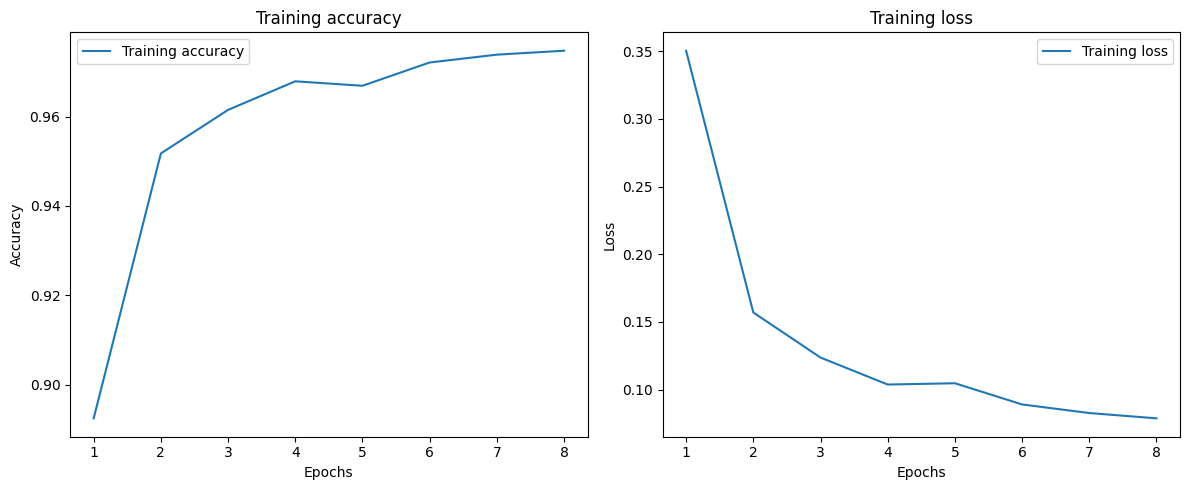

In [125]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss values from the history object
accuracy = history.history['accuracy']
loss = history.history['loss']

# Plotting
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()